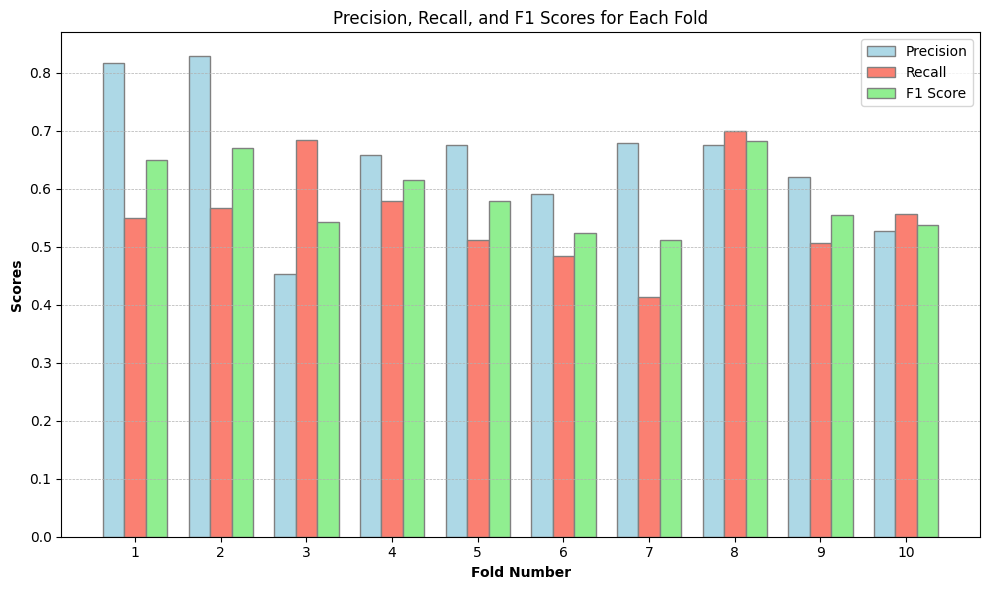

Best K: 19
Precision: 0.8519, Recall: 0.7188, F1 Score: 0.7797


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

# Load the data
data = pd.read_csv('cleveland.csv')
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 40, 50, 60, 70, 100], labels=[1, 2, 3, 4, 5, 6])
features = ['age_group', 'thalach', 'exang', 'oldpeak']

# KNN function
def knn(X_train, y_train, X_test, k):
    distances = np.sqrt(np.sum((X_train - X_test) ** 2, axis=1))
    nearest_neighbors = np.argsort(distances)[:k]
    nearest_labels = y_train.iloc[nearest_neighbors]
    prediction = Counter(nearest_labels).most_common(1)[0][0]
    return prediction

# Cross-validation function
def cross_validate(X_train, y_train, k, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        predictions = [knn(X_fold_train.values, y_fold_train, x, k) for x in X_fold_val.values]
        
        precision = precision_score(y_fold_val, predictions)
        recall = recall_score(y_fold_val, predictions)
        f1 = f1_score(y_fold_val, predictions)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    return precision_scores, recall_scores, f1_scores

# To evaluate all features
def evaluate_all_features(k_values=range(1, 21), num_folds=10):
    X = data[features]
    y = data['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_k = None
    best_f1_mean = 0
    best_precision = None
    best_recall = None
    all_f1_scores = []
    all_precision_scores = []
    all_recall_scores = []

    for k in k_values:
        precision_scores, recall_scores, f1_scores = cross_validate(X_train, y_train, k, num_folds)
        mean_f1 = np.mean(f1_scores)
        all_f1_scores.append(f1_scores)
        all_precision_scores.append(precision_scores)
        all_recall_scores.append(recall_scores)

        if mean_f1 > best_f1_mean:
            best_f1_mean = mean_f1
            best_k = k
            best_precision = np.mean(precision_scores)
            best_recall = np.mean(recall_scores)
    
    # Final evaluation on the test set using the best k
    final_predictions = [knn(X_train.values, y_train, x, best_k) for x in X_test.values]
    final_precision = precision_score(y_test, final_predictions)
    final_recall = recall_score(y_test, final_predictions)
    final_f1 = f1_score(y_test, final_predictions)
    
    return {
        'k': best_k,
        'precision': final_precision,
        'recall': final_recall,
        'f1': final_f1,
        'all_f1_scores': all_f1_scores,
        'all_precision_scores': all_precision_scores,
        'all_recall_scores': all_recall_scores
    }
results = evaluate_all_features()

#data for plotting using mean scores for each fold
mean_precision_per_fold = np.mean(results['all_precision_scores'], axis=0)
mean_recall_per_fold = np.mean(results['all_recall_scores'], axis=0)
mean_f1_per_fold = np.mean(results['all_f1_scores'], axis=0)
folds = list(range(1, len(mean_precision_per_fold) + 1))

#using histogram to visualize each folds best values
bar_width = 0.25
r1 = np.arange(len(folds))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 6))
plt.bar(r1, mean_precision_per_fold, color='lightblue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, mean_recall_per_fold, color='salmon', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, mean_f1_per_fold, color='lightgreen', width=bar_width, edgecolor='grey', label='F1 Score')
plt.xlabel('Fold Number', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(folds))], folds)
plt.title('Precision, Recall, and F1 Scores for Each Fold')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best K: {results['k']}")
print(f"Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, F1 Score: {results['f1']:.4f}")
